The software should be able to:
1) Calculate the power spectrum of a time series (following the Frandsen et al. 1995 Sect 4.2 prescription; see previous slide).
- The user should be able to input the frequency interval for the power spectrum as well as the frequency sampling in the power spectrum. The software may suggest “good” values for these input.

DONE! Here, it suggests good values for df to be 1/5T, and for frequency intervals to be those which observe peaks which are at least 1/8th the size of the maximum peak.


- The software may be built to run through a looped subroutine that calculate the power for each frequency using the Frandsen equations.
DONE!

- It is recommended the software subtracts the mean value of the time series to avoid the “zerofrequency” dominating the spectrum.
DONE! This is done using the signal.detrend() function.

- Input/Output should be in microHz, but make sure you feed the harmonic functions with angular frequency.
DONE! the mHz part. But, I don't think i fed the harmonic functions with angular frequency... yet my results look good?

- The output should be a file containing all the values for the power (or amplitude) for all the user defined frequencies. In addition, let the software plot the power spectrum on the screen or to file.

- To test the software: 
(1) Calculate the power spectrum of a simple harmonic oscillator (try vary the frequency, and amplitude of the oscillator and the length of the time series, and show it behaves as it should). 

(2) Calculate the power spectrum of stellar data (get it from www.physics.usyd.edu.au/~stello/timeseries). Try plot a spectrum of STAR1, STAR2, or the Sun where you zoom in on some of the oscillation frequencies. Show that the stars are oscillating in modes that can not be characterized by a number of simple harmonic oscillations (each mode is not described by a single sinc-like function). 

----------------------------------

2) Make your software able to use statistical weights associated with each data point in the time series.
- To test your weight functionality, try plot the power spectrum of Procyon with and without weights (get it from www.physics.usyd.edu.au/~stello/timeseries) using the SNR weight scheme/column. 
DONE! But have not used Procyon... I will need to ask Dennis what each of the columns are representing...

Also, might be able to add a feature which calculates the scatter using a box average (see 37 of L4)

----------------------------------

3) Enable the software to calculate the spectral window at a given frequency (calculate the power for a simple sine having frequency f and a cosine having frequency f. The average power spectrum is the best value for the window at frequency f, hence Window=0.5[P(sin)+P(cos)]). It is often best to choose f = 0.5fNyquist. 


To test the spectral window calculation: 
- (1) Generate time series consisting of two equal-length segments and vary the gap between the two segments from no-gap till a gap of, say, four times the length of each segment. 

- (2) Calculate the spectral window for each of your time series (single segment, two segments without gap, two segments with small gap, two segments with larger gap, etc) and show how the change in gap length changes the spectral window. 

- (3) Describe the changes and why you see what you see.


In [13]:
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

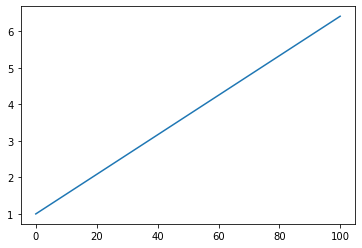

In [200]:
# Generate Random Data

# Parameters
dt = 0.05 # Timestep
df = 2 # Frequency sample step
T = 100 # End time.

time = np.arange(0, T, dt)
w = 2  # Frequency of the cosine function
a0 = 3 # Ampltiude of the cosine function
noise_level_1 = 0.2  # Standard deviation of the noise
noise_level_2 = 0.2*10  # Standard deviation of the noise

# Generate data following the trend cos(w*t) with random noise
signal_1 = a0*np.cos(w * time) + np.random.normal(scale=noise_level_1, size=len(time)) + 8*np.cos(5 * time) + np.random.normal(scale=noise_level_1*8, size=len(time))
signal_2 = a0*np.cos(w * time) + np.random.normal(scale=noise_level_2, size=len(time)) + 10

unc = 0.4*(max(signal_1)-1)/T*time + 1
plt.plot(time, unc)

# Stack time and signal_1 arrays horizontally
data = np.column_stack((time, signal_1, signal_2, unc))

# Save as CSV
np.savetxt('mockdata.csv', data, delimiter=',', header='time,signal_1,signal_2,unc', comments='')

No uncertainties detected. No weighting will be used.
Recommended sampling frequency: 0.0020 Hz.
No frequency step given. Using recommended df = 0.0020
No frequency interval given. Testing from 0 to 0.9 * Nyquist Frequency, [0, 9.0].


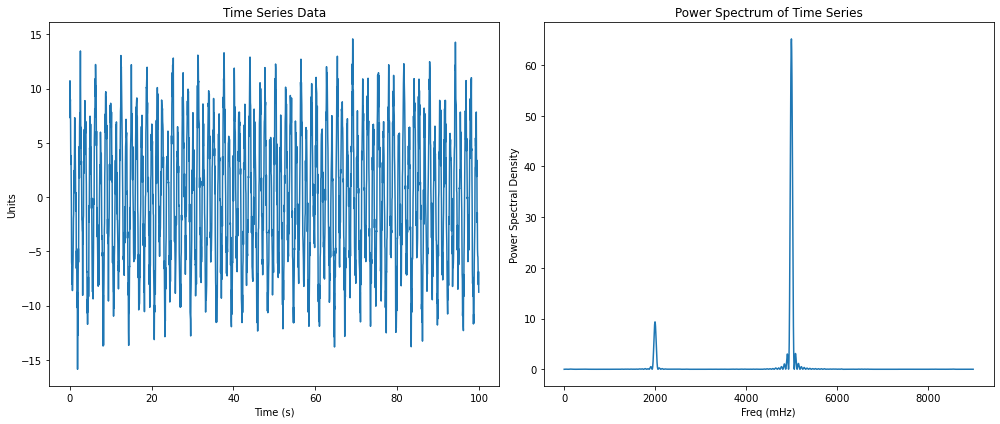

Recommended frequency interval: [1788.8944472236117, 5244.622311155578] mHz.


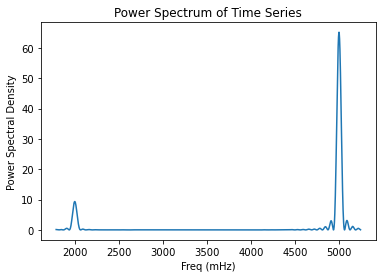

In [206]:
from scipy import signal

####################################
# USER INPUTS
data_path = 'mockdata.csv'  # Path to CSV file. NOTE: ASSUMES TIME IS IN SECONDS.
column_of_interest = 'signal_1'
df = None  # Frequency step
f_int = None  # Frequency interval
verbose = 5  # Verbosity level
recommendations = True

####################################
# READING, CLEANING, & STRUCTURING DATA
# Read the CSV file into a DataFrame
data = pd.read_csv(data_path)
time = data['time']
signal_1 = data['signal_1']
signal_2 = data['signal_2']
try:
    unc = data['unc']
    #raise KeyError
except KeyError:
    print("No uncertainties detected. No weighting will be used.")
    unc = np.ones(len(signal_1))

weights = 1/unc**2

# Removes peak at 0 Hz from signals.
signal_1 = signal.detrend(signal_1, type='linear')
signal_2 = signal.detrend(signal_2, type='linear')

# Create the xarray Dataset
ds = xr.Dataset(
    {
        'signal_1': (['time'], signal_1),
        'signal_2': (['time'], signal_2),
        'weights': (['time'], weights),
    },
    coords={
        'time': time,
    }
)

signal = column_of_interest

# Set Up Key Values
time_diff = ds['time'].diff('time')
dt = time_diff.mean().item()  # Average timestep of data
T = (ds['time'][-1] - ds['time'][0]).item()  # Time length of data
f_nyq = 1/(2*dt)  # Nyquist Frequency (Hz)
df_rec = 1/(5*T)  # Recommended sampling frequency. This oversamples using df = 1/5T.
f_int_nyq = [0, f_nyq*0.9]  # Recommended frequency interval. From 0 to 0.9 * Nyquist Frequency.

if recommendations == True:
    print(f"Recommended sampling frequency: {df_rec:.4f} Hz.")

# Check and set default values for frequency step and interval
if df is None:
    if verbose > 0:
        print(f"No frequency step given. Using recommended df = {df_rec:.4f}")
    df = df_rec

if f_int is None:
    if verbose > 0:
        print(f"No frequency interval given. Testing from 0 to 0.9 * Nyquist Frequency, {f_int_nyq}.")
    f_int = f_int_nyq

# Create frequency array
freq = np.arange(f_int[0], f_int[1], step=df)
ds.coords['freq'] = freq

####################################
# FOURIER TRANSFORM CODE
# Precompute sin(f*time) and cos(f*time)
sin_vals = np.sin(np.outer(freq, ds['time']))
cos_vals = np.cos(np.outer(freq, ds['time']))

# Compute s, c, ss, cc, sc
s_data = np.sum(ds['weights'].values * ds[signal].values * sin_vals, axis=1)
c_data = np.sum(ds['weights'].values * ds[signal].values * cos_vals, axis=1)
ss_data = np.sum(ds['weights'].values * sin_vals**2, axis=1)
cc_data = np.sum(ds['weights'].values * cos_vals**2, axis=1)
sc_data = np.sum(ds['weights'].values * cos_vals * sin_vals, axis=1)

# Add computed values to the dataset
ds['s'] = ('freq', s_data)
ds['c'] = ('freq', c_data)
ds['ss'] = ('freq', ss_data)
ds['cc'] = ('freq', cc_data)
ds['sc'] = ('freq', sc_data)

# Compute alpha and beta
alpha = (ds['s']*ds['cc']-ds['c']*ds['sc'])/(ds['ss']*ds['cc']-ds['sc']**2)
beta = (ds['c']*ds['ss']-ds['s']*ds['sc'])/(ds['ss']*ds['cc']-ds['sc']**2)

# Add alpha and beta to the dataset
ds['alpha'] = ('freq', alpha.data)
ds['beta'] = ('freq', beta.data)

# Compute power spectrum
P = ds['alpha']**2 + ds['beta']**2
ds['P'] = ('freq', P.data)

ds['freq'] = ds['freq']*1e3 # convert from Hz to mHz

####################################
# PLOTTING
# Create a figure and two subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot the time series data on the first subplot
ds['signal_1'].plot(ax=axes[0])
axes[0].set_title("Time Series Data")
axes[0].set_xlabel("Time (s)")
axes[0].set_ylabel("Units")

# Plot the power spectral density on the second subplot
ds['P'].plot(ax=axes[1])
axes[1].set_title("Power Spectrum of Time Series")
axes[1].set_xlabel("Freq (mHz)")
axes[1].set_ylabel("Power Spectral Density")

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()
plt.close()

####################################
# FINDING RECOMMENDED F INTERVAL
# Compute the index of the maximum value of ds['P'], ignoring NaNs
max_idx = np.nanargmax(ds['P'].values)
max_freq = ds['freq'].values[max_idx] # freq which produces maximum power.
max_P = ds['P'].values[max_idx] # maximum power
peak_thresh = 1/8*max_P # threshhold for other signficant peaks. Significant if 1/8 of the max peak.

# Find the frequencies where ds['P'] is greater than the threshold, and select the max and min freq values.
above_threshold_indices = np.where(ds['P'].values > peak_thresh)[0]
max_fthresh = ds['freq'].values[above_threshold_indices].max()
min_fthresh = ds['freq'].values[above_threshold_indices].min()

# New recommended frequency testing interval.
f_int_rec = [min_fthresh-20*1e3/T, max_fthresh+20*1e3/T] # in mHz
f_int_rec

print(f"Recommended frequency interval: {f_int_rec} mHz.")

P_slice = ds['P'].sel(freq=slice(f_int_rec[0], f_int_rec[1]))

# Plot the power spectral density for the selected frequency range
P_slice.plot()
plt.title("Power Spectrum of Time Series")
plt.xlabel("Freq (mHz)")
plt.ylabel("Power Spectral Density")
plt.show()
plt.close()

In [171]:
1/T*1e3
















10.005002501250624